# Modern Forecasting in Practice
## Session 2: Energy Demand & Local Models

In this session we will:
* Look at a energy demand forecasting case study
* Understand the business problem
* Set up the appropriate extrinsic and intrinsic evaluation
    * Learn about the newsvendor model
* Local Forecasting Techniques
    * Baselines: Naive, Seasonal Naive, Climatological, NPTS, Tile
    * Linear Regression
        * Quantile Regression
        * Commonly-used features
        * Lags
    * Dynamic Models
        * Exponential Smoothing
        * ARIMA
        * Linear-Gaussian State Space Models

In [1]:
import darts
from darts.models.forecasting.forecasting_model import ForecastingModel
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-notebook')
plt.rcParams['figure.figsize'] = (16,6)
import logging
logging.getLogger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# monkey patch a method for extracting the i-th sample into darts.TimeSeries

import xarray as xr

def sample(self, i):
    new_data = self._xa.values[:, :, i:i+1]
    cnames = [f"{comp}_{i}" for comp in self.components]
    new_xa = xr.DataArray(
            new_data,
        
            dims=self._xa.dims,
            coords={self._xa.dims[0]: self.time_index, darts.timeseries.DIMS[1]: pd.Index(cnames)},
            attrs=self._xa.attrs,
        )

    return self.__class__(new_xa)
    
darts.TimeSeries.sample = sample

In [3]:
from darts.logging import raise_if_not
from darts.metrics.metrics import multi_ts_support, multivariate_support, _get_values_or_raise
from typing import Callable, Union, Sequence
from darts import TimeSeries
@multi_ts_support
@multivariate_support
def quantile_loss(
    actual_series: Union[TimeSeries, Sequence[TimeSeries]],
    pred_series: Union[TimeSeries, Sequence[TimeSeries]],
    rho: float = 0.5,
    intersect: bool = True,
    *,
    reduction: Callable[[np.ndarray], float] = np.mean,
    inter_reduction: Callable[[np.ndarray], Union[float, np.ndarray]] = lambda x: x,
    n_jobs: int = 1,
    verbose: bool = False
) -> float:

    z_true, z_hat = _get_values_or_raise(
        actual_series,
        pred_series,
        intersect,
        stochastic_quantile=None,
        remove_nan_union=True,
    )

    if len(z_hat.shape) < 3:
        z_hat_rho = z_hat.squeeze()
    else:
        z_hat_rho = np.quantile(z_hat, q=rho, axis=2).squeeze()

    z_true = z_true.squeeze()

    pred_above = np.where(z_hat_rho >= z_true, 1, 0)
    pred_below = np.where(z_hat_rho < z_true, 1, 0)

    rho_loss = 2 * (z_true - z_hat_rho) * (rho * pred_below - (1 - rho) * pred_above)
    
    return np.sum(rho_loss)

## Load Data
We'll use the energy dataset from https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

In [4]:
from darts.datasets import EnergyDataset

In [5]:
energy_data = EnergyDataset().load()

In [6]:
energy_data.components

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object', name='component')

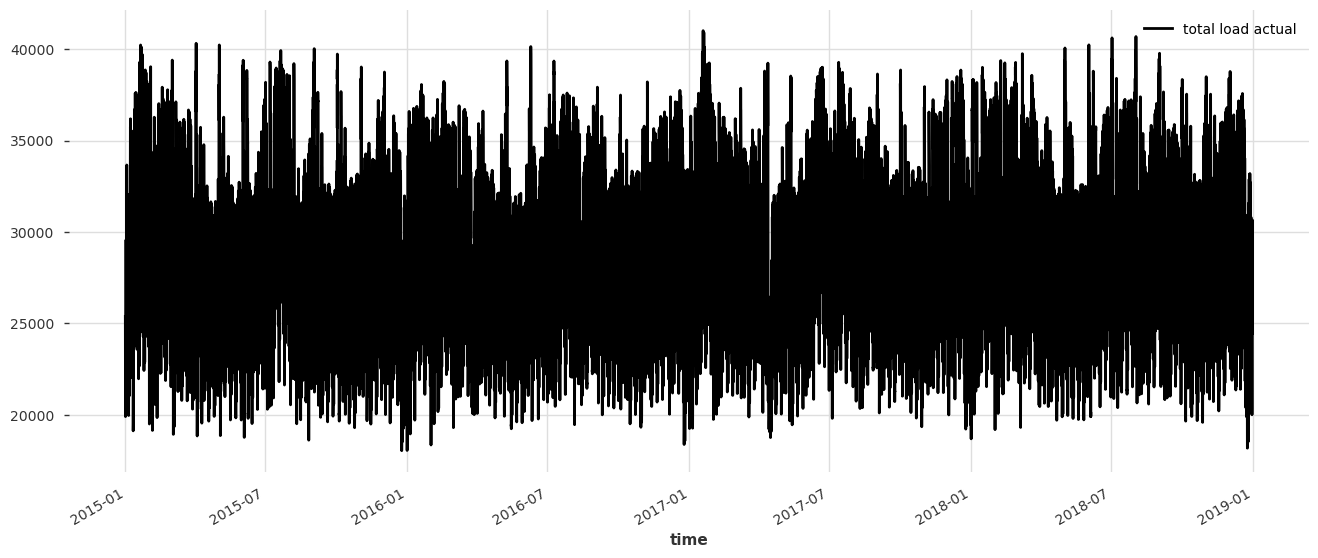

In [7]:
energy_data["total load actual"].plot()

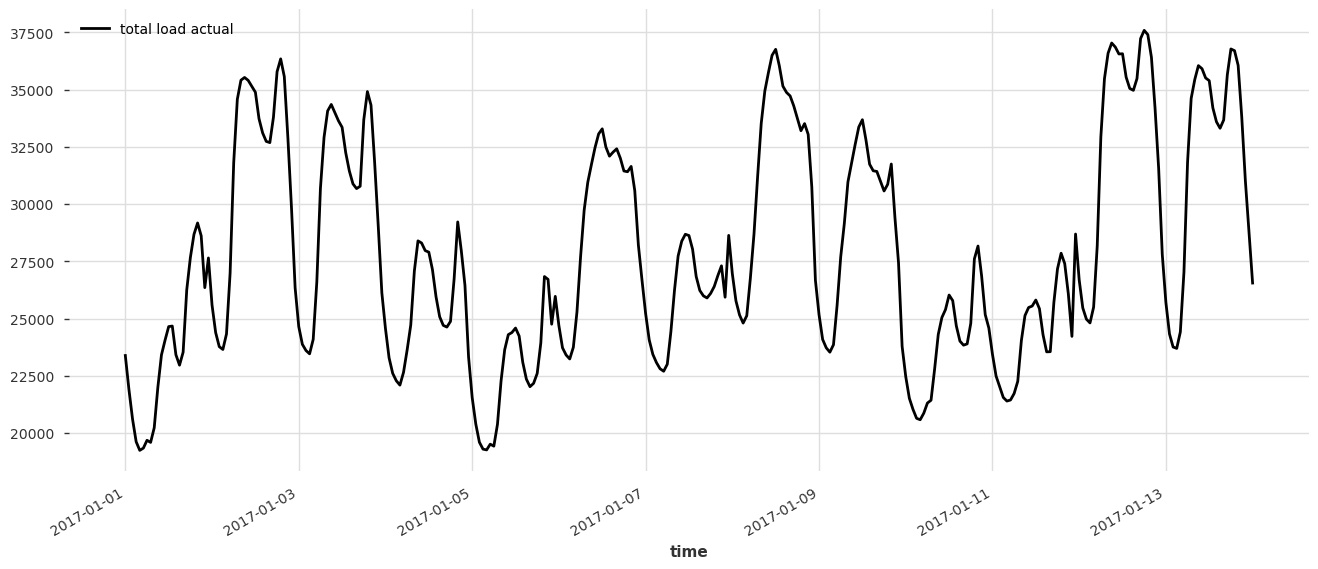

In [8]:
energy_data["total load actual"][pd.Timestamp("2017-01-01"):pd.Timestamp("2017-01-14")].plot()

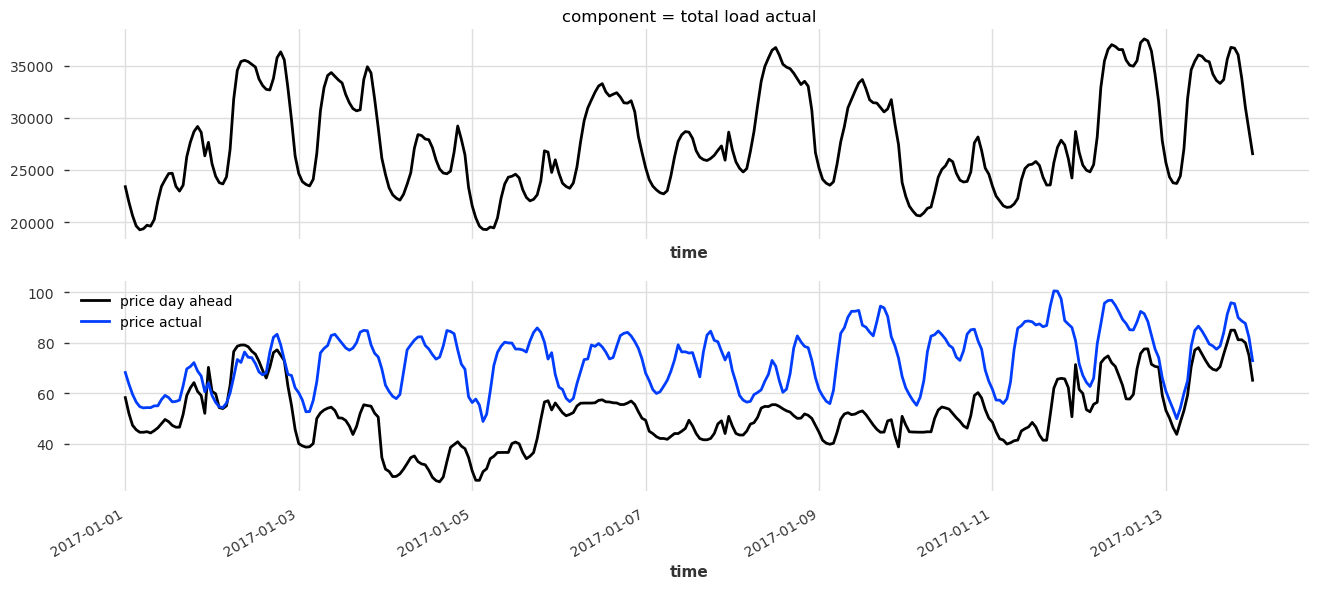

In [9]:
fig, axs = plt.subplots(2, 1, sharex=True)
timeframe = slice(pd.Timestamp("2017-01-01"), pd.Timestamp("2017-01-14"))
energy_data["total load actual"][timeframe].plot(ax=axs[0])
energy_data[["price day ahead", "price actual"]][timeframe].plot(ax=axs[1])

In [10]:
train, test = energy_data["total load actual"].split_before(pd.Timestamp("20180101"))
train_all_components, test_all_components = energy_data.split_before(pd.Timestamp("20180101"))

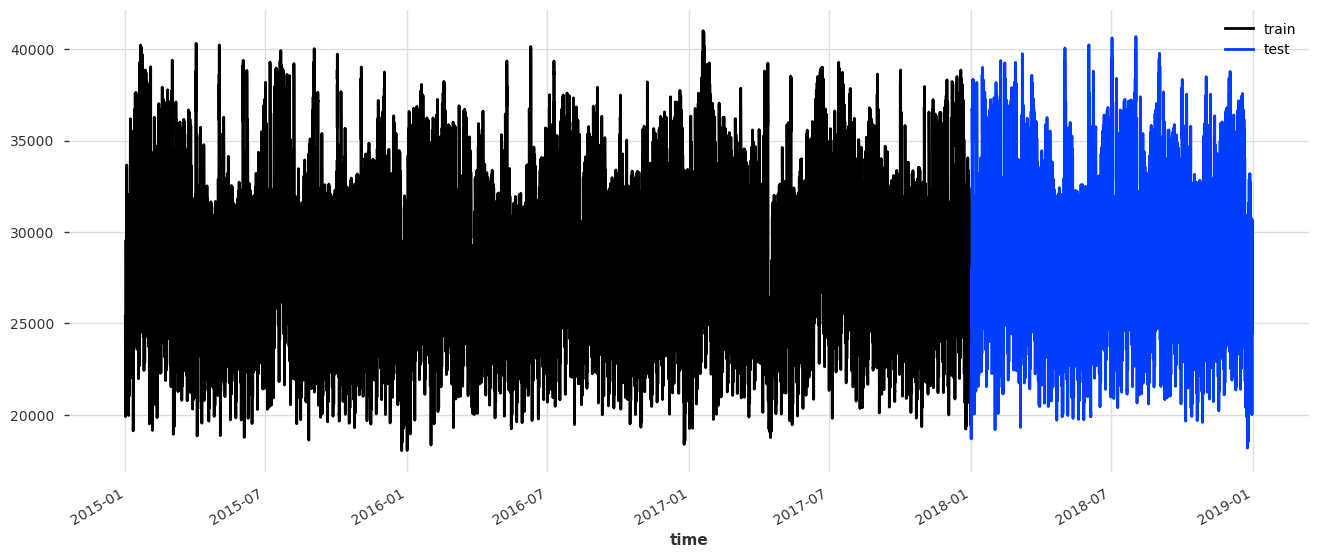

In [11]:
train.plot(label="train")
test.plot(label="test")

# Baseline Methods

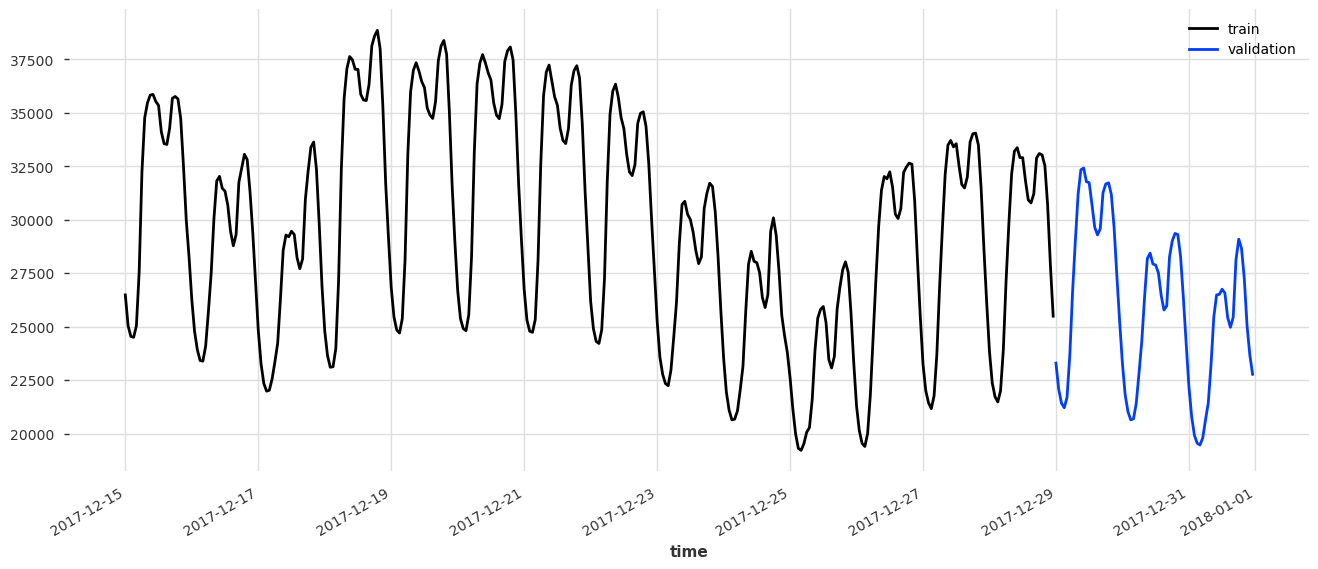

In [12]:
TRAIN_LEN, VAL_LEN = 14 * 24, 3 * 24
train_short = train_all_components["total load actual"][-TRAIN_LEN - VAL_LEN:-VAL_LEN]
validation_all_components = train_all_components[-VAL_LEN:]
validation = train_all_components["total load actual"][-VAL_LEN:]
train_short.plot(label="train")
validation.plot(label="validation")

# Naive Forecast

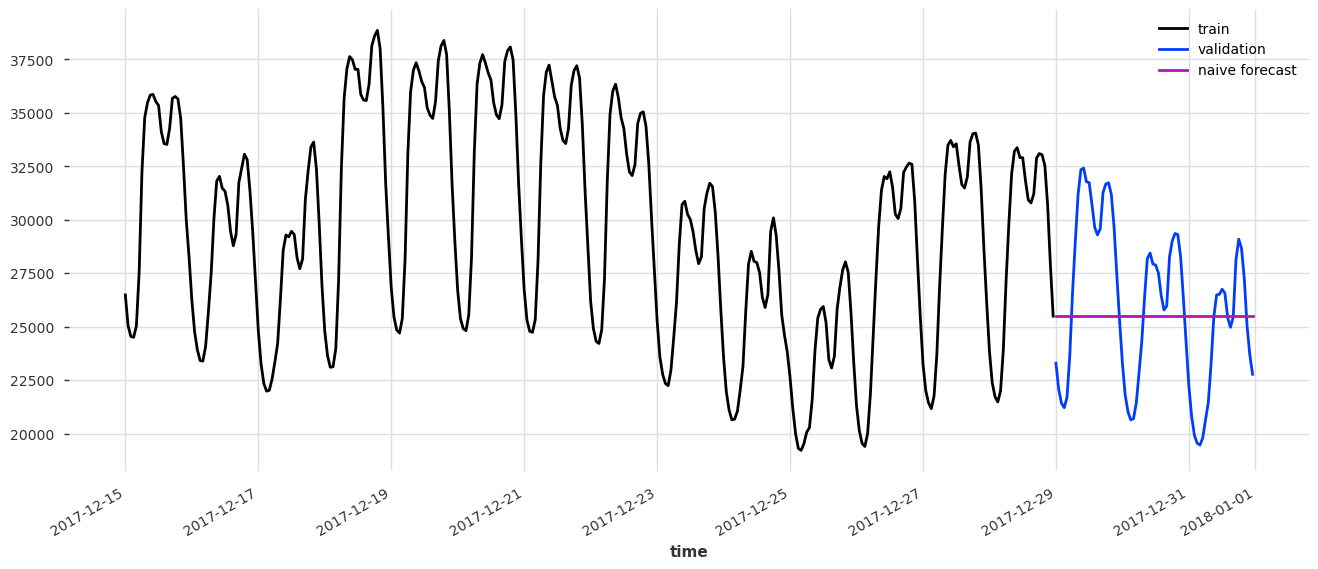

In [13]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train_short)
naive_forecast = naive_model.predict(VAL_LEN)

train_short.plot(label="train")
validation.plot(label="validation")
naive_forecast.plot(label="naive forecast")

# Mean Forecast

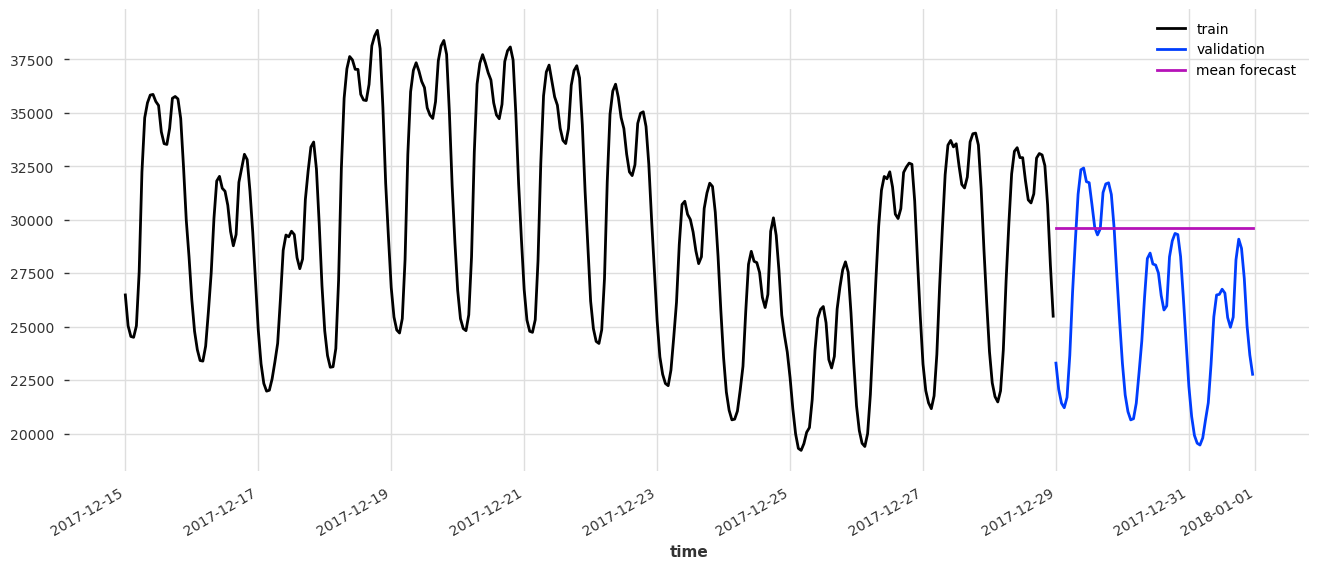

In [14]:
from darts.models import NaiveMean

naive_mean = NaiveMean()
naive_mean.fit(train_short)
mean_forecast = naive_mean.predict(VAL_LEN)

train_short.plot(label="train")
validation.plot(label="validation")
mean_forecast.plot(label="mean forecast")

# Naive Seasonal Forecast

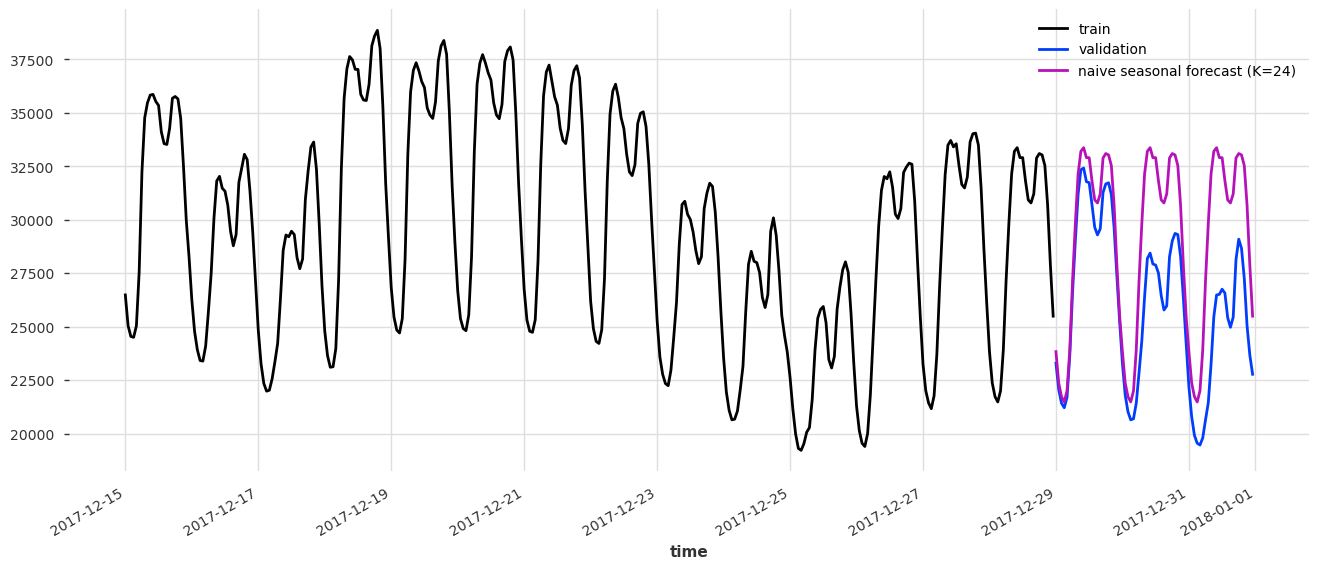

In [15]:
from darts.models import NaiveSeasonal

naive_seasonal_model = NaiveSeasonal(K=24)
naive_seasonal_model.fit(train_short)
naive_seasonal_forecast = naive_seasonal_model.predict(VAL_LEN)

train_short.plot(label="train")
validation.plot(label="validation")
naive_seasonal_forecast.plot(label="naive seasonal forecast (K=24)")

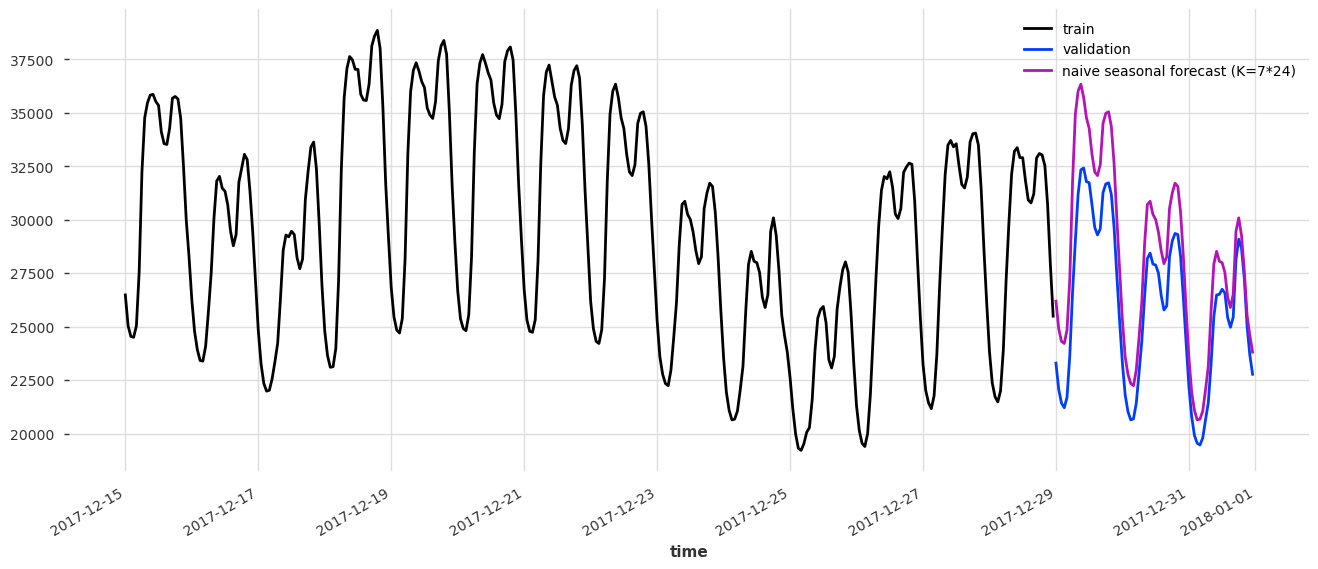

In [16]:
from darts.models import NaiveSeasonal

naive_seasonal_model = NaiveSeasonal(K=7*24)
naive_seasonal_model.fit(train_short)
naive_seasonal_forecast = naive_seasonal_model.predict(VAL_LEN)

train_short.plot(label="train")
validation.plot(label="validation")
naive_seasonal_forecast.plot(label="naive seasonal forecast (K=7*24)")

# Shout Out
How would you turn the seasonal naive forecaster into a probabilistic forecaster?

# Climatological Forecast

In [17]:
class Climatological(ForecastingModel):
    def __init__(self):
        super().__init__()
        
    def _is_probabilistic(self):
        return True
    
    def fit(self, series: darts.TimeSeries):
        super().fit(series)
    
    def predict(self, n: int, num_samples: int = 1):
        values = self.training_series.values().squeeze()
        samples = np.random.choice(values[np.isfinite(values)], (n, num_samples))
        return self._build_forecast_series(np.expand_dims(samples, axis=1), self.training_series)

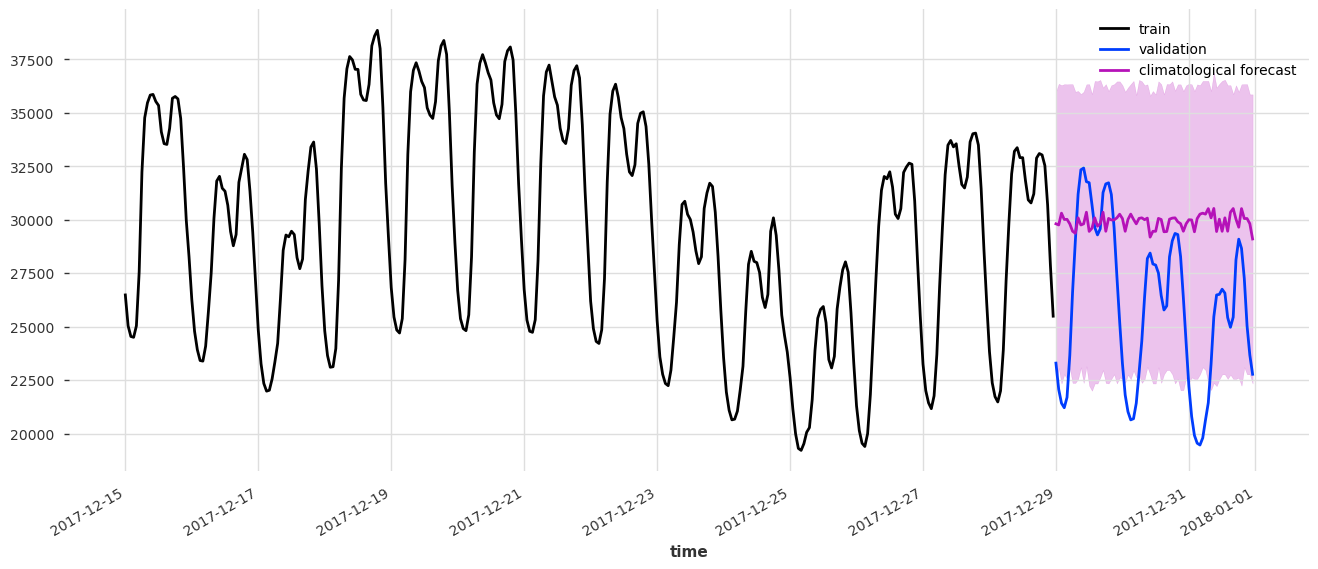

In [18]:
climatological_model = Climatological()
climatological_model.fit(train_short)
climatological_forecast = climatological_model.predict(VAL_LEN, num_samples=1000)

train_short.plot(label="train")
validation.plot(label="validation")
climatological_forecast.plot(label="climatological forecast", low_quantile=0.1, high_quantile=0.9)

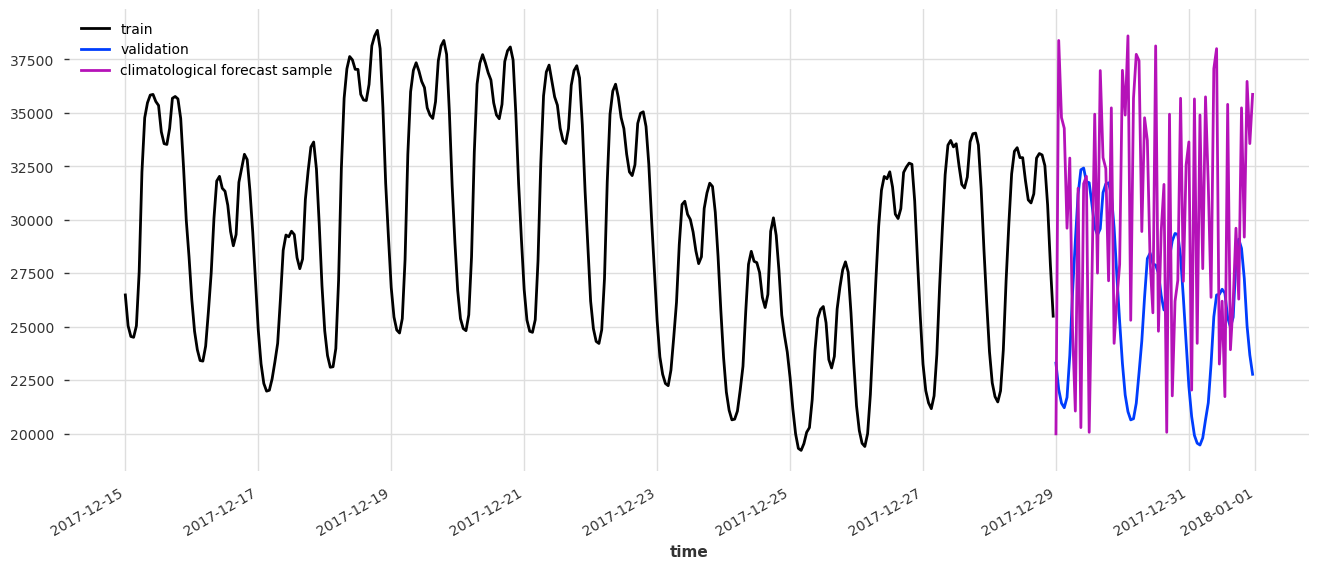

In [19]:
train_short.plot(label="train")
validation.plot(label="validation")
for i in range(1):
    climatological_forecast.sample(i).plot(label="climatological forecast sample")

# Poll

## Why do you think is the climatological forecaster a useful baseline?

# Shout Out
Where would the climatological forecaster run into problems? How would you fix this?

# Tile Forecast

In [38]:
class ProbabilisticTileForecast(ForecastingModel):
    def __init__(self, K=7*24, num_tiles=None):
        super().__init__()
        self.K = K
        self.num_tiles = num_tiles
        
    def _is_probabilistic(self):
        return True
    
    def fit(self, series: darts.TimeSeries):
        super().fit(series)
    
    def predict(self, n: int, num_samples:int = 0):
        if self.num_tiles is None or self.num_tiles * self.K > self.training_series.n_timesteps:
            num_tiles = self.training_series.n_timesteps // self.K
        else:
            num_tiles = self.num_tiles
        values = self.training_series.values().squeeze()[-num_tiles * self.K:]
        samples = np.expand_dims(values.reshape((num_tiles, self.K)).T, axis=1)
        tiled_samples = np.tile(samples, ((n - 1) // self.K + 1, 1, 1))
        return self._build_forecast_series(tiled_samples[:n,:,:], self.training_series)

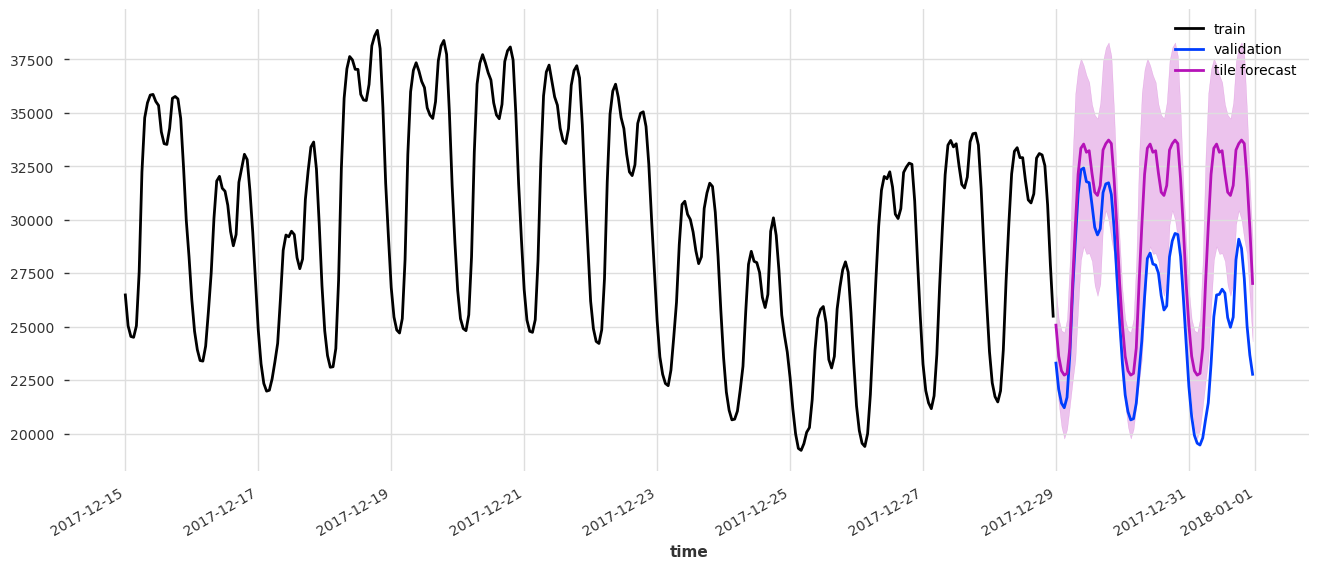

In [42]:
tile_model = ProbabilisticTileForecast(K=24, num_tiles=14)
tile_model.fit(train_short)
tile_forecast = tile_model.predict(VAL_LEN, num_samples=100)

train_short.plot(label="train")
validation.plot(label="validation")
tile_forecast.plot(label="tile forecast", low_quantile=0.1, high_quantile=0.9)

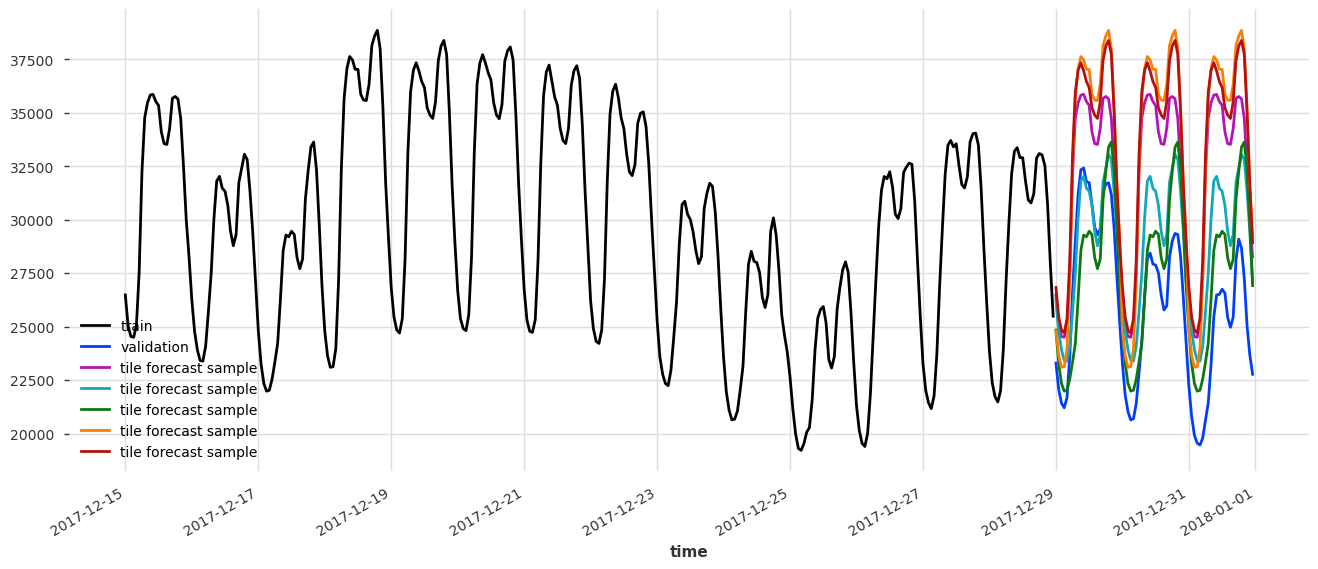

In [43]:
train_short.plot(label="train")
validation.plot(label="validation")
for i in range(5):
    tile_forecast.sample(i).plot(label="tile forecast sample")

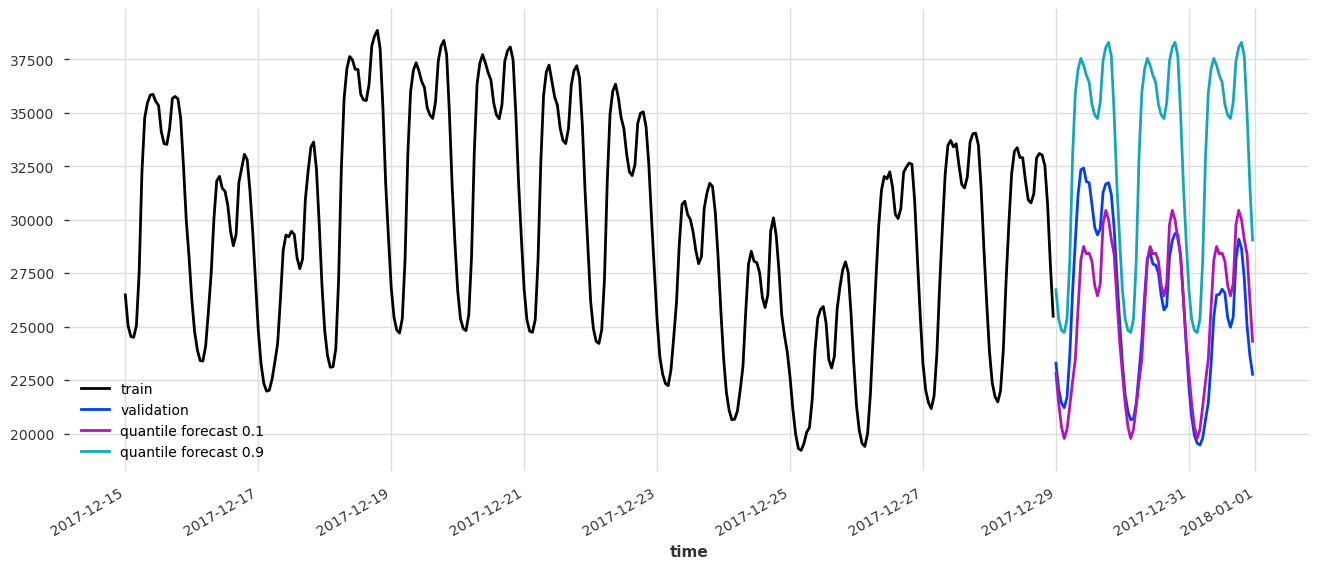

In [44]:
train_short.plot(label="train")
validation.plot(label="validation")
tile_forecast.quantile_timeseries(0.1).plot(label="quantile forecast 0.1")
tile_forecast.quantile_timeseries(0.9).plot(label="quantile forecast 0.9")

# Back to the slides

# Back to the Optimization Problem

$$
\min_{V, b} \mathbb{E}\left[ \sum_t \left( \pi_t V_t + c^-_t[b_t]_- + c^+_t[b_t]_+\right)\right]
$$
subject to $V_t - b_t = \delta_t$.

Here
* $V_t$ = purchase quantity
* $\delta_t$ = demand
* $\pi_t$ = price
* $c_t^-$ = cost for balancing energy deficit ("cost_underbuy")
* $c_t^+$ = cost balancing excess energy ("cost_overbuy")


# Back to the Optimization Problem: Simplification

$$
\min_V \mathbb{E}\left[ \sum_t \left( \pi_t V_t + c^-_t[V_t - \delta_t]_- + c^+_t[V_t - \delta_t]_+\right)\right] = \min_V \mathbb{E}[\text{cost}]
$$

Here
* $V_t$ = purchase quantity
* $\delta_t$ = demand
* $\pi_t$ = price
* $c_t^-$ = cost for balancing energy deficit ("cost_underbuy")
* $c_t^+$ = cost balancing excess energy ("cost_overbuy")

In [45]:
def cost(true_demand, purchase_qty, price, cost_overbuy, cost_underbuy):
    return (   price * purchase_qty
             + cost_underbuy * (purchase_qty < true_demand) * (true_demand - purchase_qty) 
             + cost_overbuy  * (purchase_qty > true_demand) * (purchase_qty - true_demand)
           )

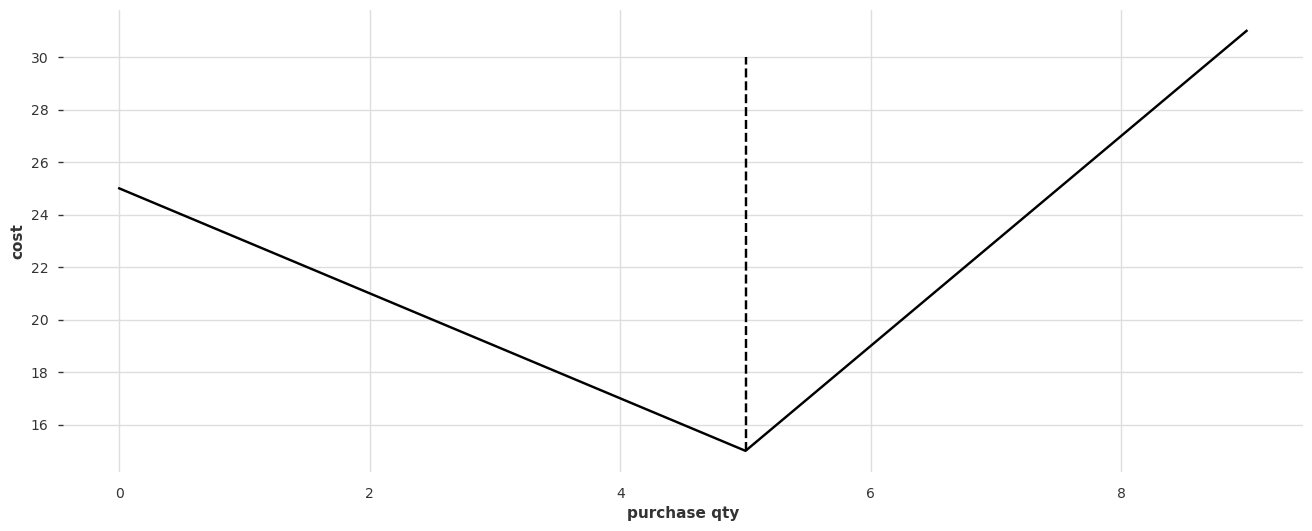

In [46]:
xx = np.arange(0, 10)
plt.plot(xx, cost(5, xx, 3, 1, 5))
plt.ylabel("cost")
plt.xlabel("purchase qty")
plt.vlines(5, ymin=15, ymax=30, linestyles="--")

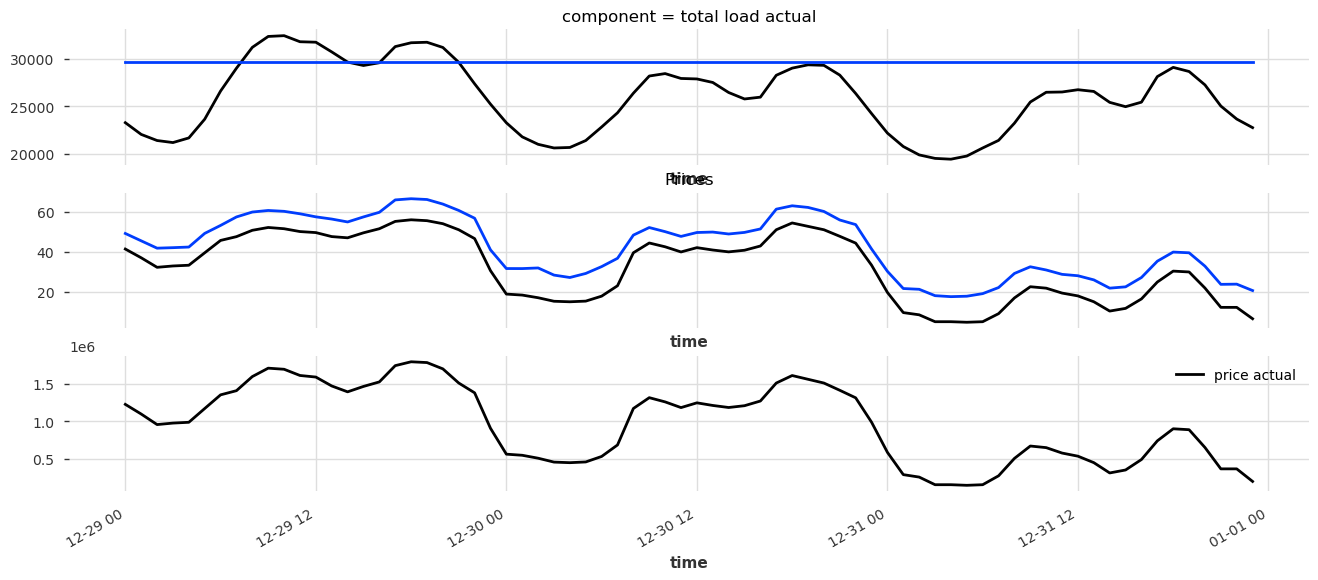

In [48]:
price_day_ahead = validation_all_components["price day ahead"]
price_actual = validation_all_components["price actual"]
c = cost(validation.values(), mean_forecast.values(), price_day_ahead.values(), 0, price_actual.values())

fig, axs = plt.subplots(3, 1, sharex=True)
validation.plot(ax=axs[0])
mean_forecast.plot(ax=axs[0])
price_day_ahead.plot(ax=axs[1])
price_actual.plot(ax=axs[1])
axs[1].set_title("Prices")
price_actual.with_values(np.expand_dims(c, axis=1)).plot()

$$ \mathbb{E}[\text{cost}] \approx \frac{1}{N}\sum_{i=1}^N \text{cost}(\text{sample path}_i)$$

In [49]:
def expected_cost_monte_carlo(purchase_qty, predictions, price, cost_overbuy, cost_underbuy):
    sample_costs = [
        cost(true_demand=predictions.values(sample=i), 
             purchase_qty=purchase_qty,
             price=price, 
             cost_overbuy=cost_overbuy, 
             cost_underbuy=cost_underbuy)
        for i in range(predictions.n_samples)]
    return np.mean(sample_costs, axis=0)

Text(0.5, 1.0, 'Cost for buying with mean forecast')

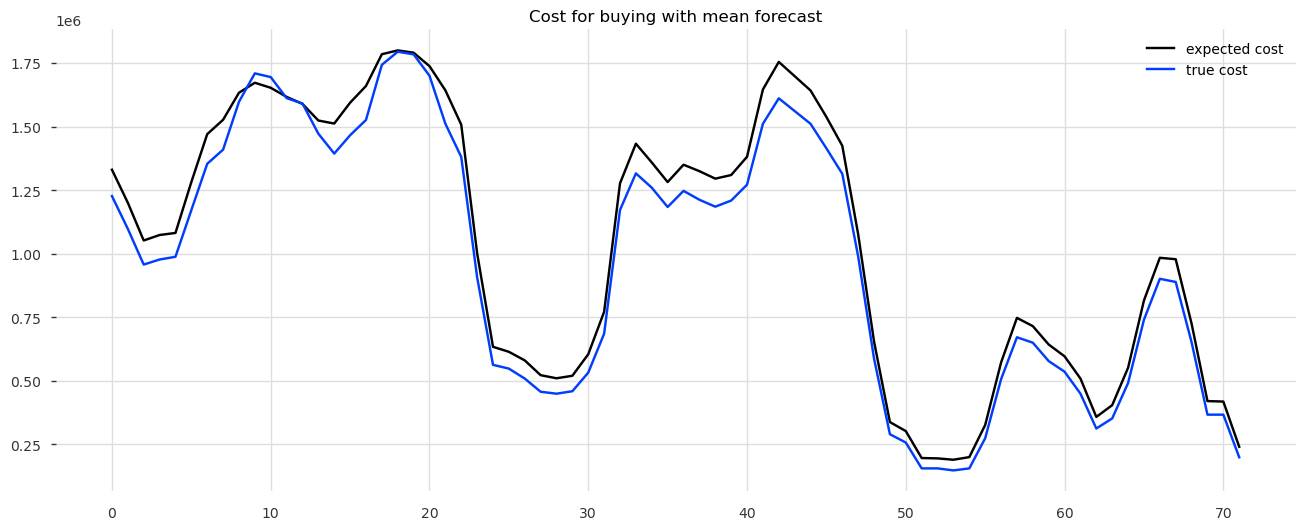

In [50]:
expected_cost = expected_cost_monte_carlo(
    mean_forecast.values(),
    climatological_forecast,
    price_day_ahead.values(),
    0,
    price_actual.values())
plt.plot(expected_cost, label="expected cost")
plt.plot(c, label="true cost")
plt.legend()
plt.title("Cost for buying with mean forecast")

# Optimal Buying
If we knew the true demand distribution, what would be the optimal purchase quantity?
* In this particular case, there is a closed-form solution in terms of the quantile function $F^{-1}$:


$$
V^* = \text{argmin}_V \mathbb{E}_{\delta \sim F}\left[ \left( \pi V + c^-[V - \delta]_- + c^+[V - \delta]_+\right)\right]
$$

$$V^* = F^{-1}\left( \frac{c^- - \pi}{c^- + c^+}\right)$$
* This optimization problem is a variant of the famous newsvendor model. 
* For more information see
  * https://en.wikipedia.org/wiki/Newsvendor_model
  * https://bpb-us-w2.wpmucdn.com/sites.gatech.edu/dist/4/1470/files/2021/03/SPbook.pdf

In [53]:
PRICE = 1.0
COST_OVERBUY = PRICE * 0.1
COST_UNDERBUY = PRICE * 1.3

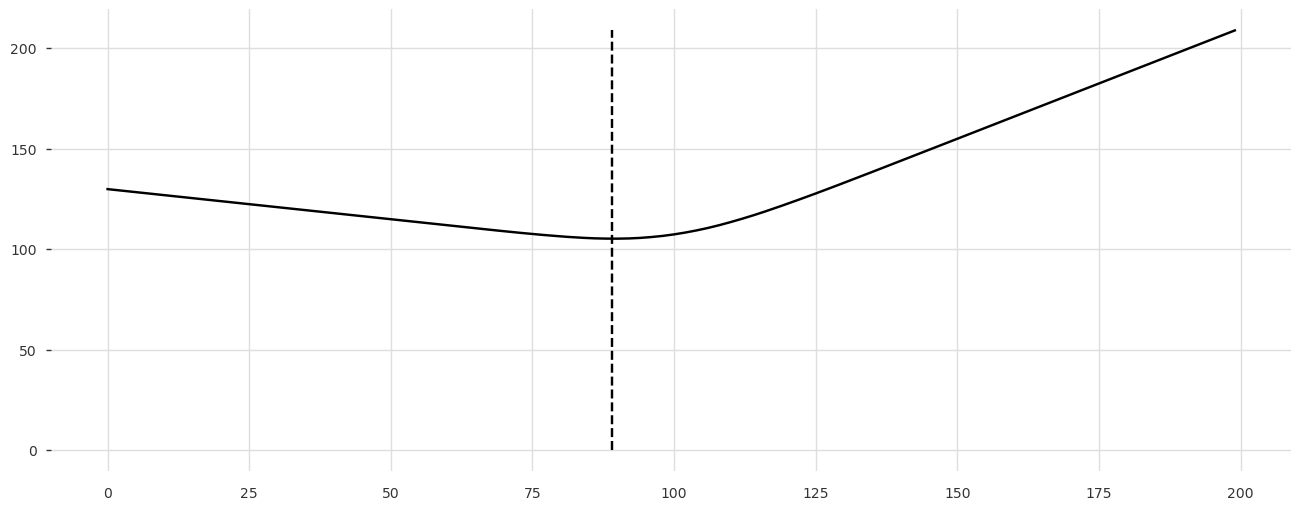

In [52]:
import scipy.stats.distributions as spd
def monte_carlo(f, predictions, **kwargs):
    return np.mean([f(predictions.values(sample=i), **kwargs) for i in range(predictions.n_samples)])

negbin_predictions = darts.TimeSeries.from_values(spd.nbinom.rvs(100, p=0.5, size=(1, 1, 1000)))
purchase_qtys = np.arange(200)

average_costs = [monte_carlo(cost, negbin_predictions, purchase_qty=x, price=PRICE, 
                             cost_overbuy=COST_OVERBUY, cost_underbuy=COST_UNDERBUY)
                 for x in purchase_qtys]

plt.plot(purchase_qtys, average_costs)
critical_ratio = (COST_UNDERBUY - PRICE) / (COST_OVERBUY + COST_UNDERBUY)
optimal_purchase_qty = spd.nbinom.ppf(critical_ratio, n=100, p=0.5)
plt.vlines(x=optimal_purchase_qty, 
           ymin=0, ymax=np.max(average_costs), linestyles='--')

In [54]:
from scipy.optimize import minimize_scalar
res = minimize_scalar(expected_cost_monte_carlo, args=(negbin_predictions, PRICE, COST_OVERBUY, COST_UNDERBUY))
res.fun, res.x, optimal_purchase_qty

(array([[105.3202]]), array([[89.0000004]]), 89.0)

In [55]:
def minimize_expected_cost_exact_multistep(predictions, price, cost_overbuy, cost_underbuy, compute_cost=True):
    critical_ratios = (cost_underbuy - price) / (cost_underbuy + cost_overbuy)
    optimal_purchase_qtys = []
    min_costs = []
    for step in range(predictions.n_timesteps):
        optimal_purchase_qty = predictions[step].quantile(critical_ratios[step]).values().squeeze()
        optimal_purchase_qtys.append(optimal_purchase_qty)
        if compute_cost:
            min_cost = expected_cost_monte_carlo(optimal_purchase_qty, predictions[step], price[step], cost_overbuy[step], cost_underbuy[step])
            min_costs.append(min_cost)
    return np.sum(min_costs), np.array(optimal_purchase_qtys).squeeze()

Expected cost under buying with mean forecast: 75.36171814002749
Expected cost under optimal decision: 73.11175229431912


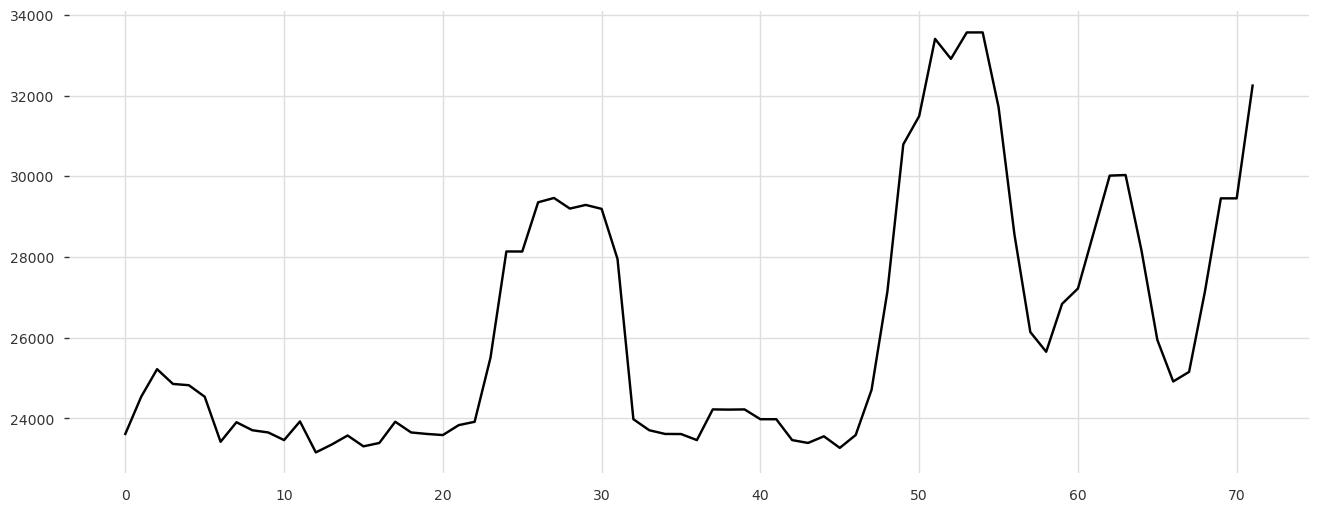

In [56]:
min_expected_cost, optimal_purchase_qtys = minimize_expected_cost_exact_multistep(
    climatological_forecast,
    price_day_ahead.values().squeeze(),
    np.zeros(VAL_LEN),
    price_actual.values().squeeze())
print("Expected cost under buying with mean forecast: {}".format(expected_cost.sum() / 1e6))
print("Expected cost under optimal decision: {}".format(min_expected_cost / 1e6))
plt.plot(optimal_purchase_qtys)

In [57]:
DAY_AHEAD_PRICE_FACTOR = 1.26
critical_ratio_extrinsic = (DAY_AHEAD_PRICE_FACTOR - 1) / DAY_AHEAD_PRICE_FACTOR

def eval_extrinsic_single(forecast, observed):
    
    if forecast.is_probabilistic:
        _, purchase_qtys = minimize_expected_cost_exact_multistep(
            predictions=forecast,
            price=observed['price day ahead'].values().squeeze(),
            cost_overbuy=np.zeros(forecast.n_timesteps),
            cost_underbuy=observed['price day ahead'].values().squeeze() * DAY_AHEAD_PRICE_FACTOR, 
            compute_cost=False)
    else:
        purchase_qtys = forecast.values().squeeze()
    
    actual_costs = cost(
        true_demand=observed['total load actual'].values().squeeze(), 
        purchase_qty=np.array(purchase_qtys),
        price=observed['price day ahead'].values().squeeze(),
        cost_overbuy=np.zeros(forecast.n_timesteps),
        cost_underbuy=observed['price actual'].values().squeeze())
    return {'extrinsic cost': actual_costs.sum() / 1e6}


def eval_extrinsic(forecasts, observed):
    metrics = []
    for forecast in forecasts:
        # restrict both series to common time points
        forecast_common = forecast.slice_intersect(observed)
        observed_common = observed.slice_intersect(forecast)
        metric = eval_extrinsic_single(forecast_common, observed_common)
        metrics.append(metric)
    return pd.DataFrame(metrics)

In [58]:
eval_extrinsic_single(climatological_forecast, validation_all_components)


{'extrinsic cost': 66.50825742285714}

(38.30717289067689, 37.89858867555167)

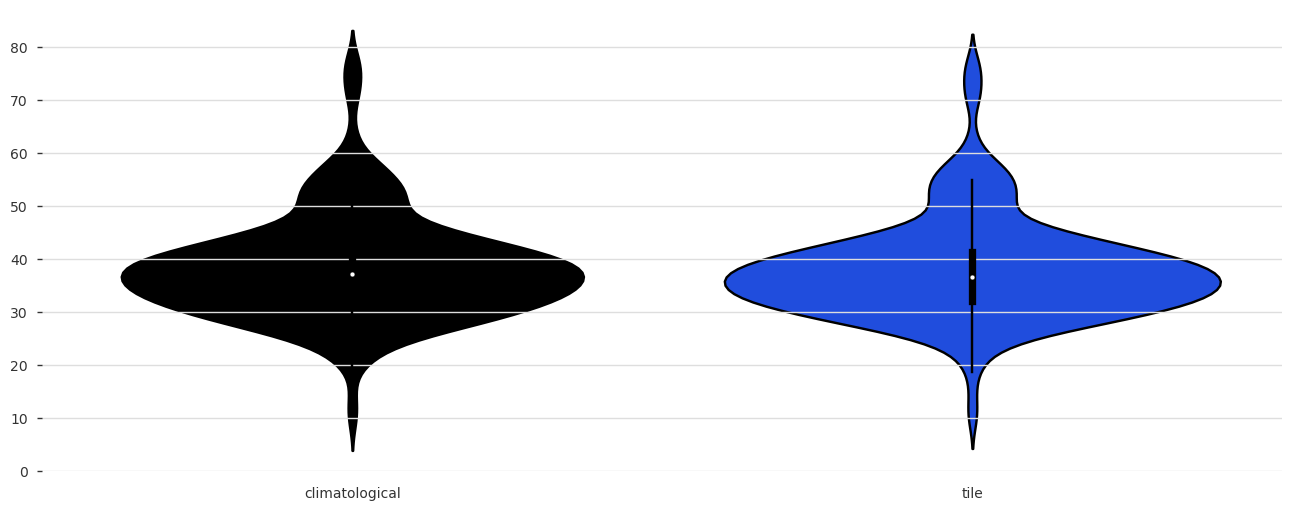

In [59]:
import seaborn
climatological_forecasts = climatological_model.historical_forecasts(
    train, 
    start=pd.Timestamp("2016-12-14"), 
    last_points_only=False, 
    stride=24, 
    forecast_horizon=24,
    num_samples=1000)
climatological_extrinsic = eval_extrinsic(climatological_forecasts, train_all_components).rename({'extrinsic cost': "climatological"}, axis=1)
tile_forecasts = tile_model.historical_forecasts(
    train, 
    start=pd.Timestamp("2016-12-14"), 
    last_points_only=False, 
    stride=24, 
    forecast_horizon=24)
tile_extrinsic = eval_extrinsic(tile_forecasts, train_all_components).rename({'extrinsic cost': "tile"}, axis=1)
results = pd.concat([climatological_extrinsic, tile_extrinsic], axis=1)
seaborn.violinplot(results)
climatological_extrinsic.mean()[0], tile_extrinsic.mean()[0]

In [60]:
def eval_intrinsic_single(forecast, observed):
    return {
        "MAE": darts.metrics.mae(observed['total load actual'], forecast),
        "wQL-crit": quantile_loss(observed['total load actual'], forecast, rho=critical_ratio_extrinsic)
    }

def eval_intrinsic(forecasts, observed):
    metrics = []
    for forecast in forecasts:
        # restrict both series to common time points
        forecast_common = forecast.slice_intersect(observed)
        observed_common = observed.slice_intersect(forecast)
        metric = eval_intrinsic_single(forecast_common, observed_common)
        metrics.append(metric)
    return pd.DataFrame(metrics)

(3915.1285653532714, 2413.788130983464)

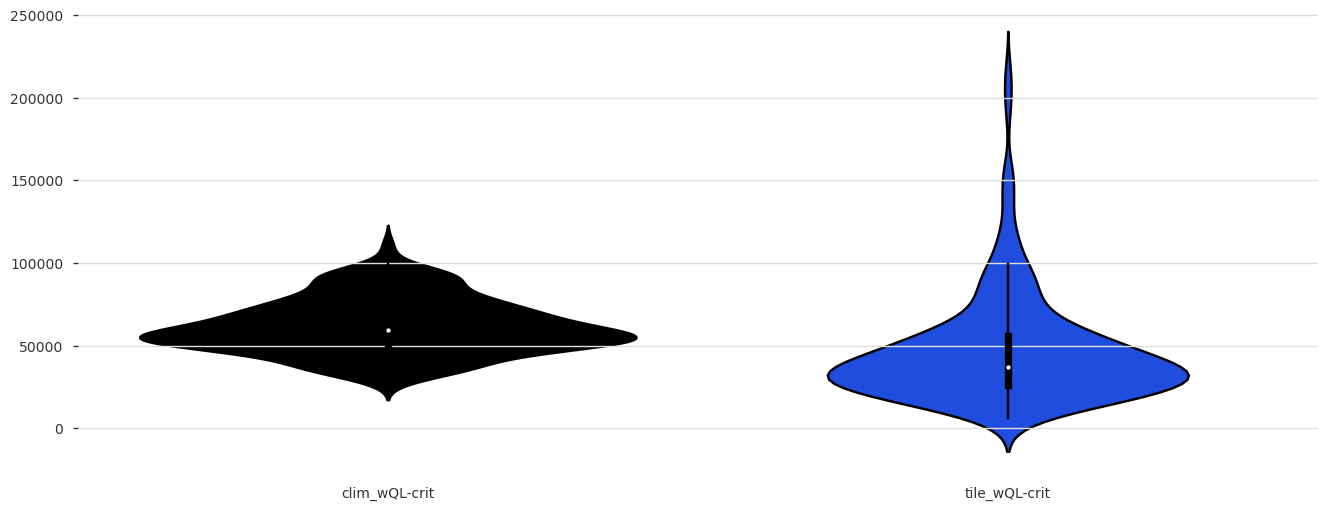

In [61]:
climatological_intrinsic = eval_intrinsic(climatological_forecasts, train).rename(lambda x: "clim_"+x, axis=1)
tile_intrinsic = eval_intrinsic(tile_forecasts, train_all_components).rename(lambda x: "tile_"+x, axis=1)
results = pd.concat([climatological_intrinsic, tile_intrinsic], axis=1)
seaborn.violinplot(results[["clim_wQL-crit", "tile_wQL-crit"]])
climatological_intrinsic.mean()[0], tile_intrinsic.mean()[0]

(array([[1.        , 0.68279897],
        [0.68279897, 1.        ]]),
 array([[1.        , 0.46883654],
        [0.46883654, 1.        ]]))

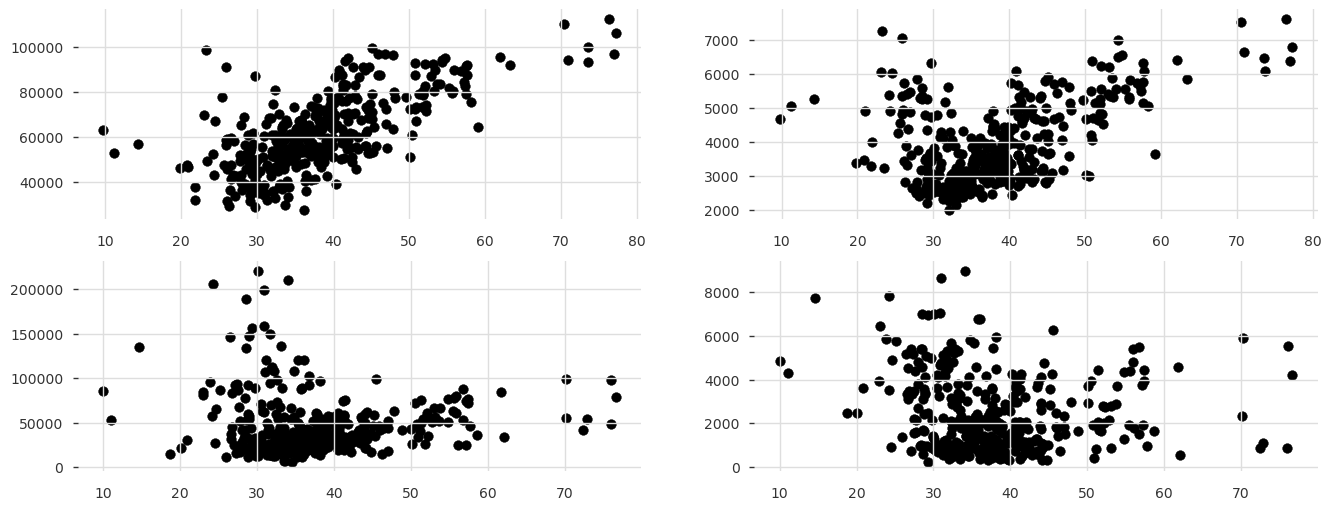

In [62]:
fig, axs = plt.subplots(2, 2)
axs[0,0].scatter(climatological_extrinsic["climatological"], climatological_intrinsic["clim_wQL-crit"])
axs[1,0].scatter(tile_extrinsic["tile"], tile_intrinsic["tile_wQL-crit"])
axs[0,1].scatter(climatological_extrinsic["climatological"], climatological_intrinsic["clim_MAE"])
axs[1,1].scatter(tile_extrinsic["tile"], tile_intrinsic["tile_MAE"])
mask = np.isfinite(climatological_extrinsic["climatological"])
np.corrcoef(climatological_extrinsic["climatological"][mask], climatological_intrinsic["clim_wQL-crit"][mask]),\
np.corrcoef(climatological_extrinsic["climatological"][mask], climatological_intrinsic["clim_MAE"][mask])

# Short Aside: Backtest Plots

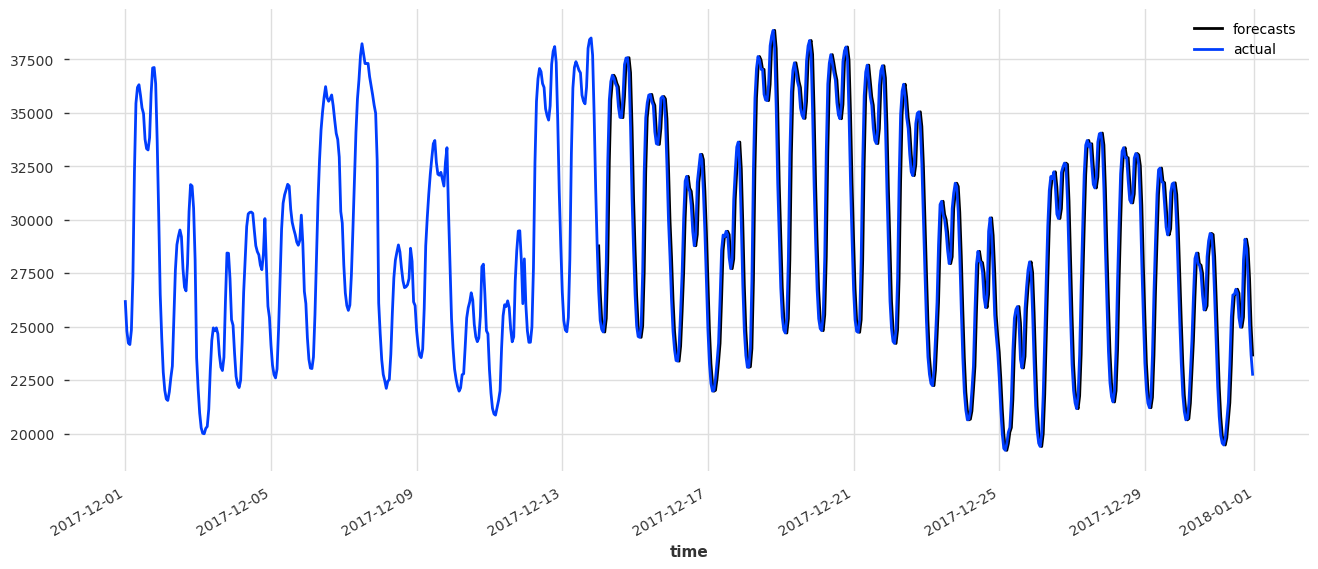

In [63]:
# DON'T DO THIS!
fct = darts.models.NaiveSeasonal(K=1).historical_forecasts(
    train, 
    start=pd.Timestamp("2017-12-14"), 
    last_points_only=False, 
    stride=1, 
    forecast_horizon=1)
fct_series = np.expand_dims(np.array([f.values()[0] for f in fct]), axis=2)
train[pd.Timestamp("2017-12-14"):].with_values(fct_series).plot(label="forecasts")
train[-31*24:].plot(label="actual")

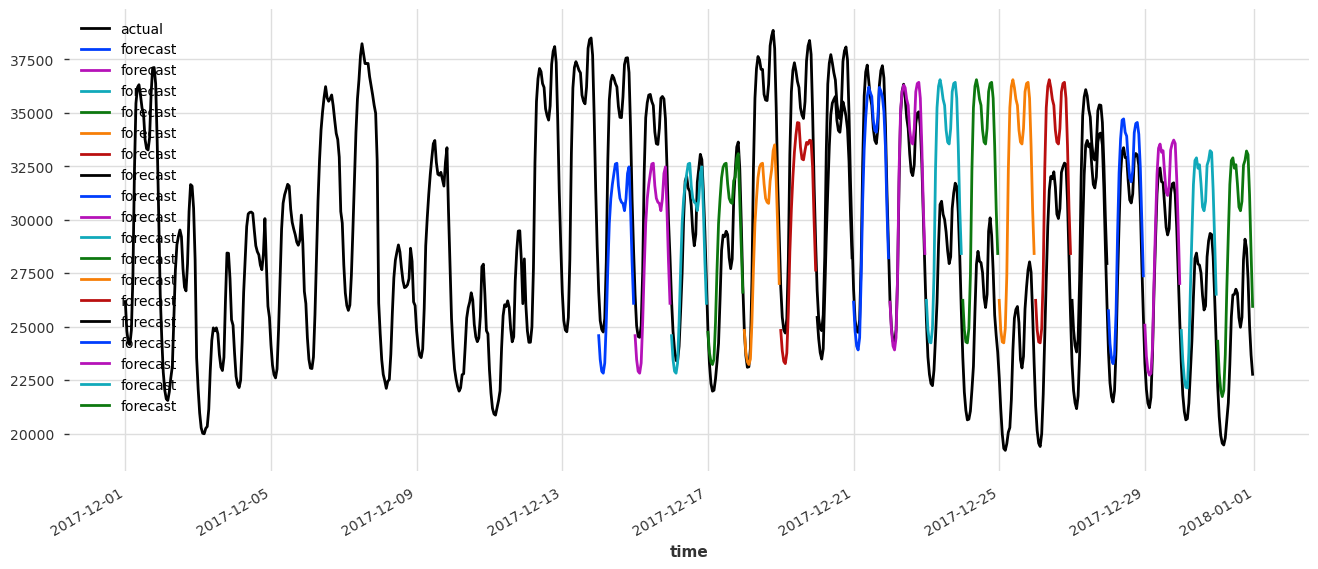

In [64]:
# DO THIS INSTEAD
fct = tile_model.historical_forecasts(
    train, 
    start=pd.Timestamp("2017-12-14"), 
    last_points_only=False, 
    stride=24, 
    forecast_horizon=24)
train[-31*24:].plot(label="actual")
for f in fct:
    f.plot(label="forecast", central_quantile=0.5, high_quantile=None, low_quantile=None)

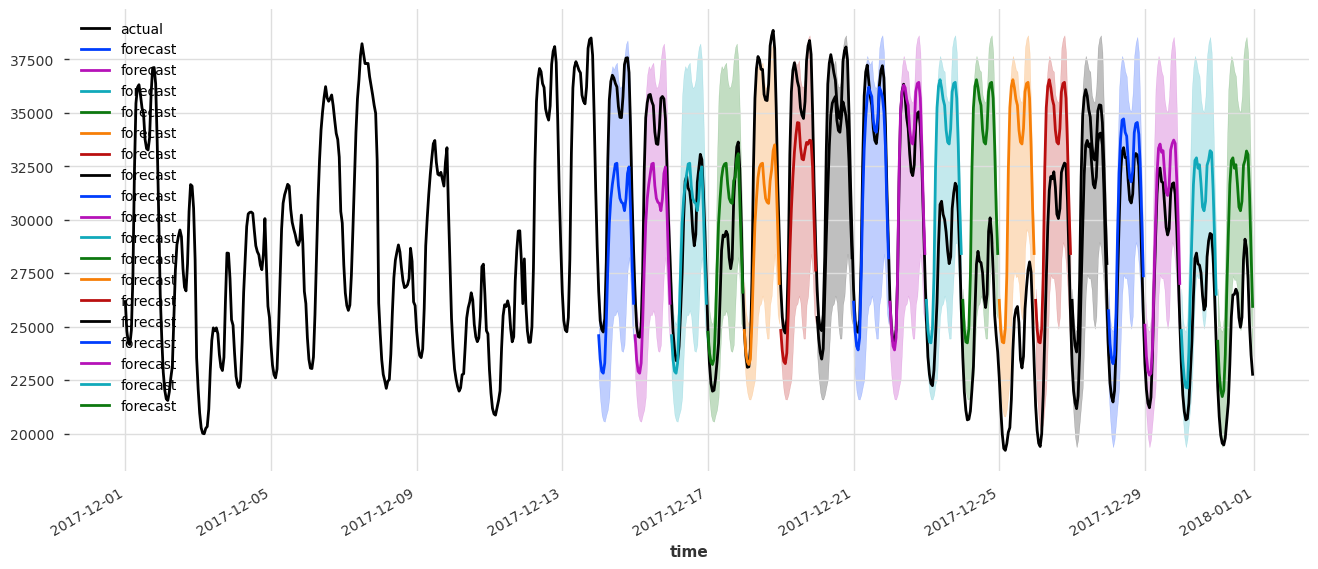

In [65]:
train[-31*24:].plot(label="actual")
for f in fct:
    f.plot(label="forecast")

# Linear Regression

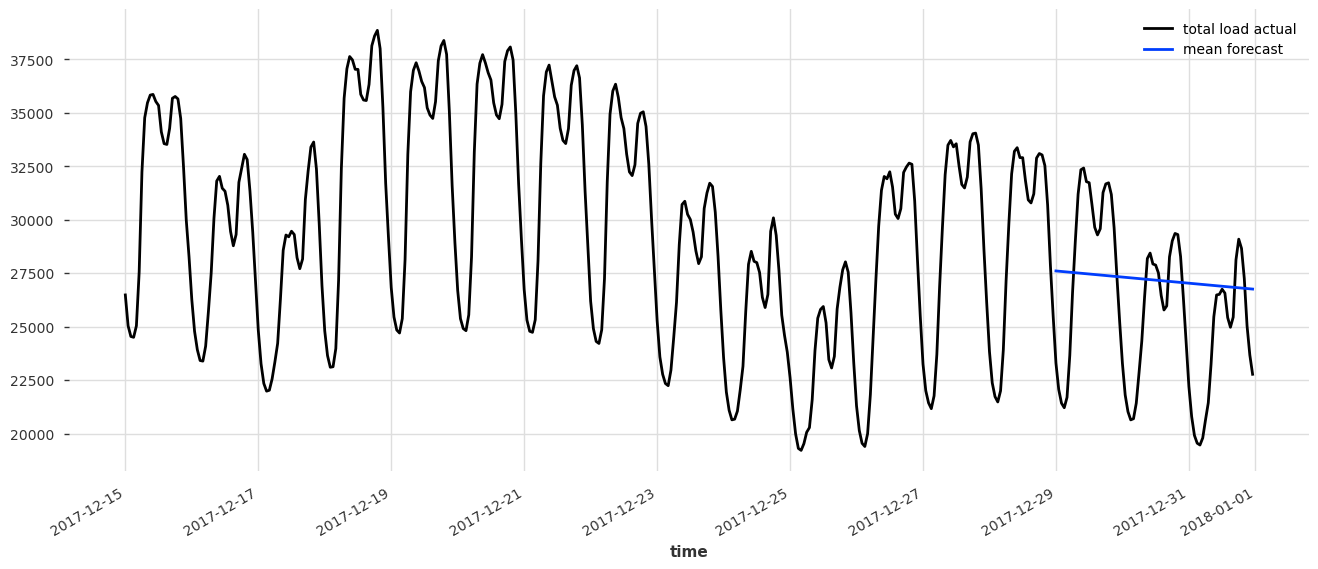

In [86]:
from darts.models import LinearRegressionModel
train_and_val = train_short.concatenate(validation)
trend_feature = darts.TimeSeries.from_times_and_values(
    train.time_index,
    np.linspace(0, 1, train.n_timesteps))
linear_regression = LinearRegressionModel(lags_future_covariates=[0])
linear_regression.fit(train_short,  future_covariates=trend_feature)
train_and_val.plot()
linear_regression.predict(VAL_LEN, future_covariates=trend_feature).plot(label="mean forecast")

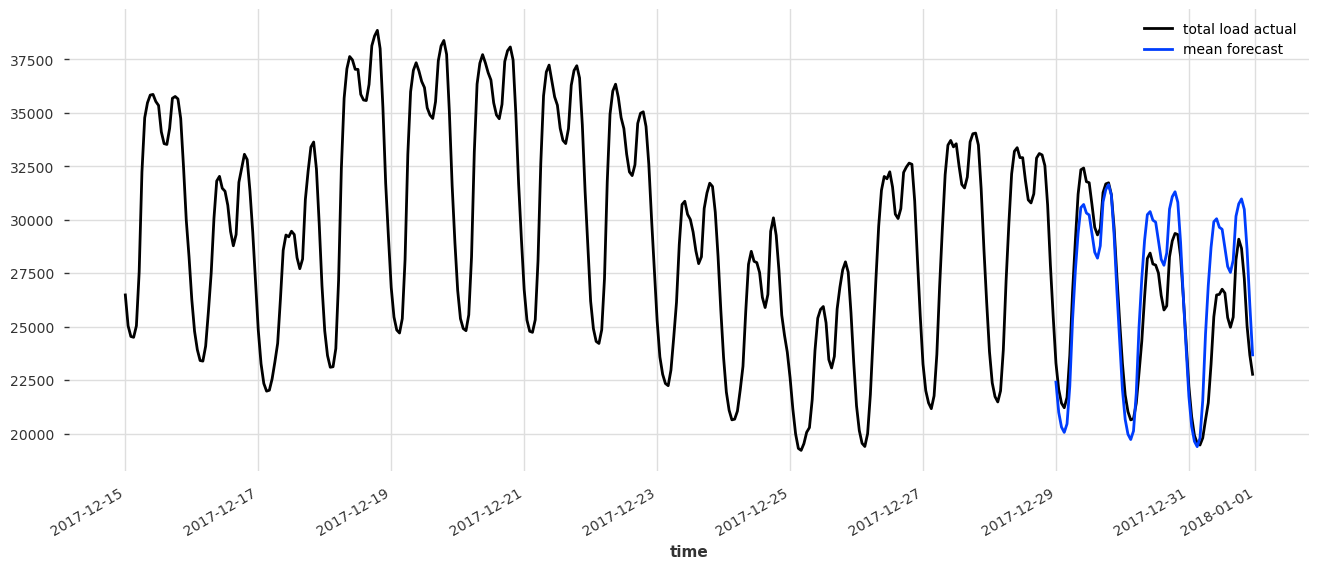

In [87]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries
hour_of_day = datetime_attribute_timeseries(train.time_index, "hour", one_hot=True)
future_covariates = darts.concatenate([trend_feature, hour_of_day], axis="component")
linear_regression.fit(train_short, future_covariates=future_covariates)
train_and_val.plot()
linear_regression.predict(VAL_LEN, future_covariates=future_covariates).plot(label="mean forecast")

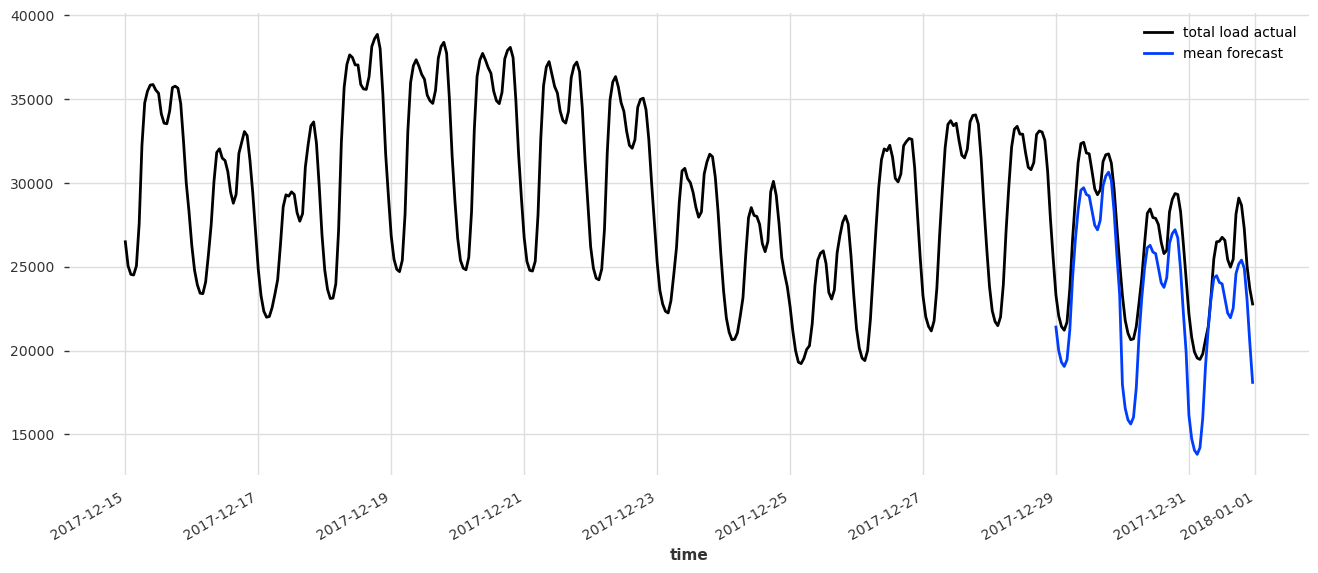

In [88]:
day_of_week = datetime_attribute_timeseries(train.time_index, "dayofweek", one_hot=True)
future_covariates = darts.concatenate([trend_feature, hour_of_day, day_of_week], axis="component")
linear_regression.fit(train_short, future_covariates=future_covariates)
train_and_val.plot()
linear_regression.predict(VAL_LEN, future_covariates=future_covariates).plot(label="mean forecast")

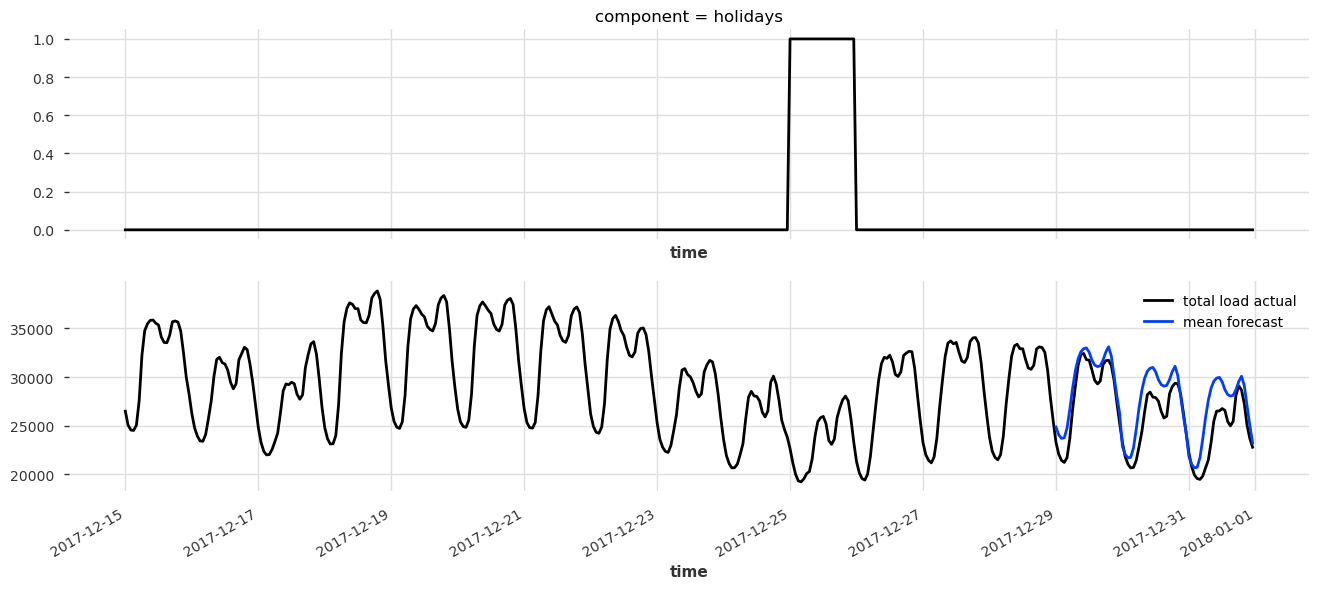

In [89]:
from darts.utils.timeseries_generation import holidays_timeseries
holidays = holidays_timeseries(train.time_index, country_code="ES")
future_covariates = darts.concatenate([trend_feature, hour_of_day, day_of_week, holidays], axis="component")
linear_regression.fit(train[:-VAL_LEN], future_covariates=future_covariates)

fig, axs = plt.subplots(2, 1, sharex=True)
holidays[-train_and_val.n_timesteps:].plot(ax=axs[0])
train_and_val.plot(ax=axs[1])
linear_regression.predict(VAL_LEN, future_covariates=future_covariates).plot(ax=axs[1], label="mean forecast")

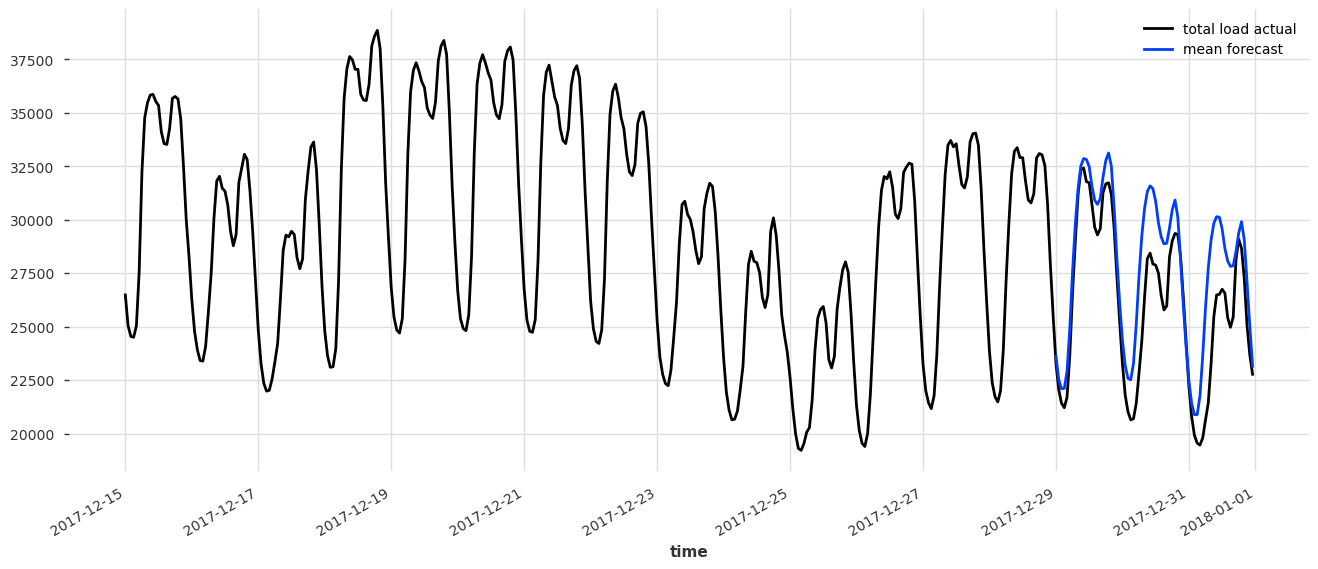

In [90]:
linear_regression = LinearRegressionModel(lags_future_covariates=[0], lags=48)
linear_regression.fit(train[:-VAL_LEN], future_covariates=future_covariates)

train_and_val.plot()
linear_regression.predict(VAL_LEN, future_covariates=future_covariates).plot(label="mean forecast")

# Poll
How many ways do you know to turn linear regression into a probabilistic forecasting method?

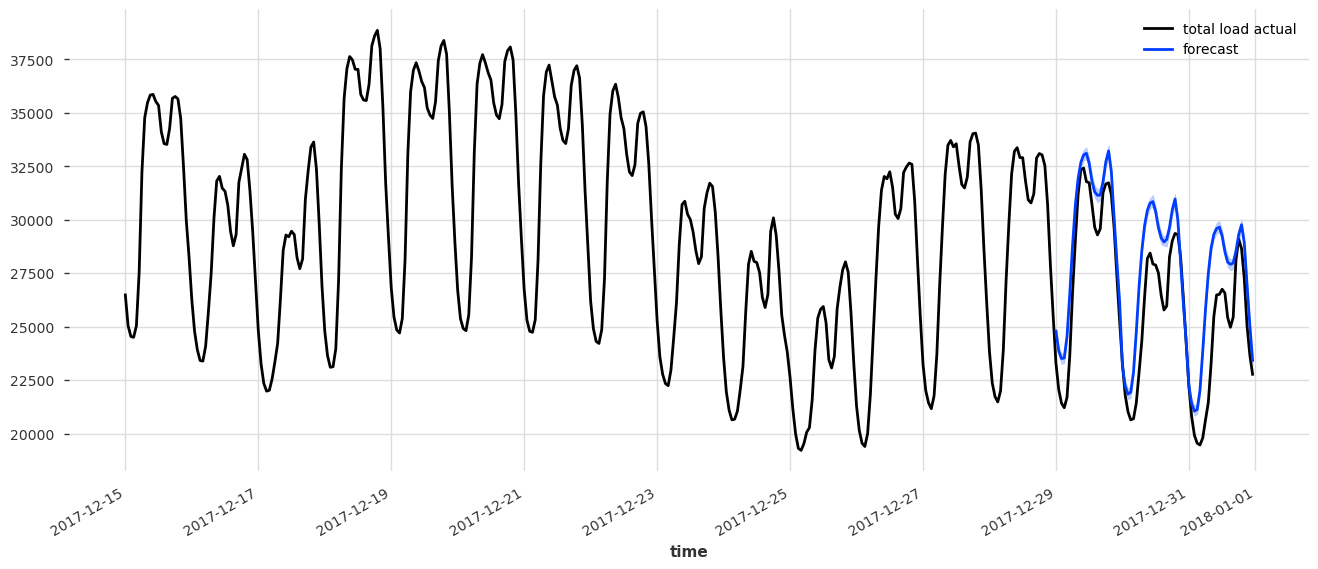

In [91]:
linear_regression = LinearRegressionModel(lags_future_covariates=[0], likelihood="poisson")
linear_regression.fit(train[:-VAL_LEN], future_covariates=future_covariates)

train_and_val.plot()
prediction = linear_regression.predict(VAL_LEN, future_covariates=future_covariates, num_samples=100)
prediction.plot(label="forecast")

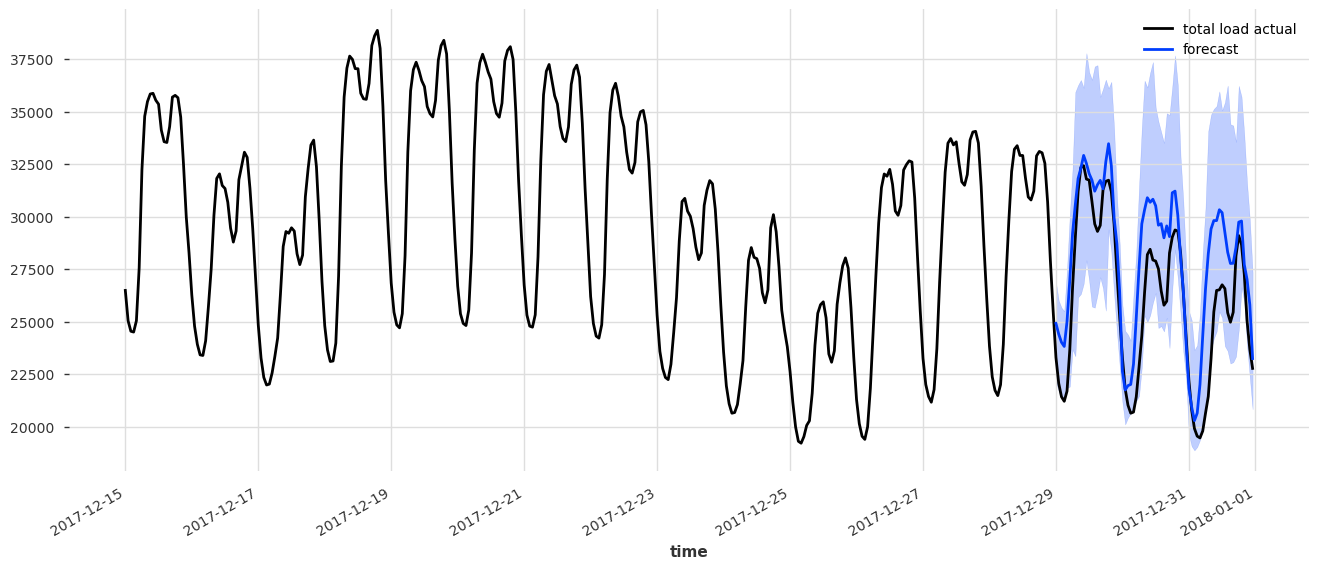

In [92]:
linear_regression = LinearRegressionModel(lags_future_covariates=[0], likelihood="quantile", alpha=0)
linear_regression.fit(train[:-VAL_LEN], future_covariates=future_covariates)

train_and_val.plot()
prediction = linear_regression.predict(VAL_LEN, future_covariates=future_covariates, num_samples=100)
prediction.plot(label="forecast")

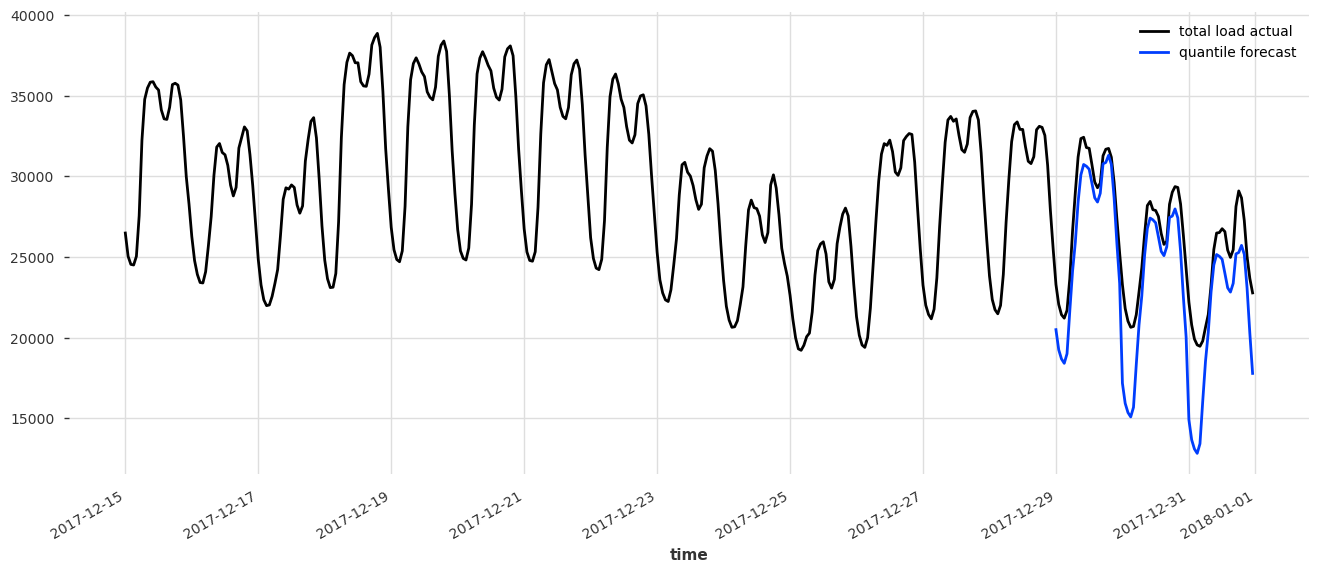

In [93]:
from darts.models import RegressionModel
from sklearn.linear_model import QuantileRegressor
quantile_regression = RegressionModel(lags_future_covariates=[0], model=QuantileRegressor(alpha=1e-5, quantile=critical_ratio_extrinsic))
quantile_regression.fit(train_short, future_covariates=future_covariates)
train_and_val.plot()
quantile_regression.predict(VAL_LEN, future_covariates=future_covariates).plot(label="quantile forecast")

(3915.1285653532714, 2413.788130983464, 3124.9833840552906)

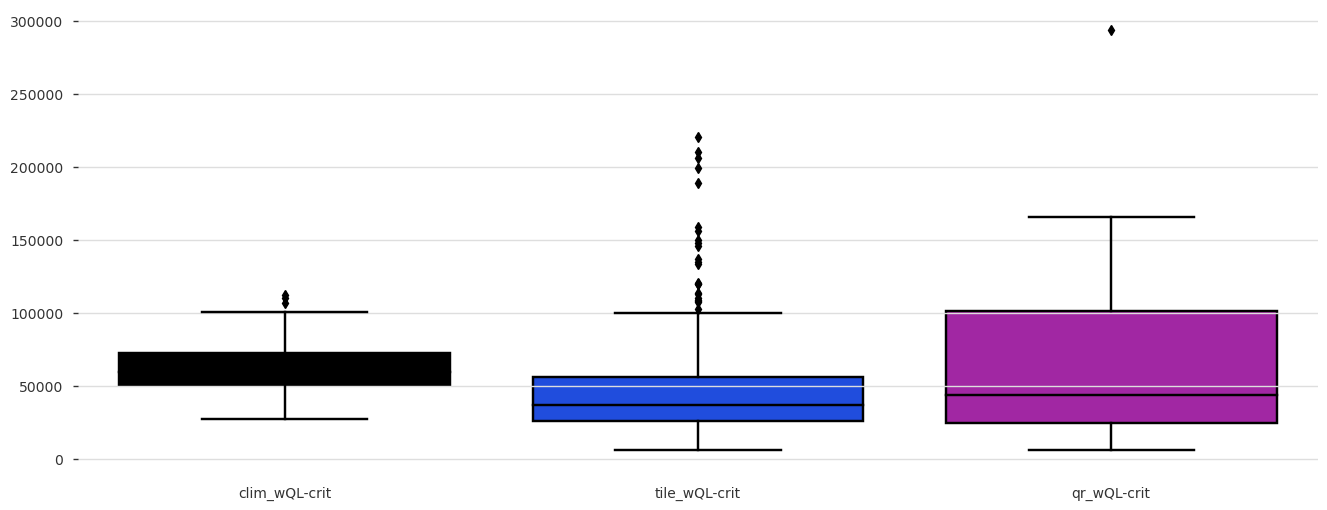

In [94]:
qr_forecasts = quantile_regression.historical_forecasts(
    train, 
    start=pd.Timestamp("2017-12-14"), 
    last_points_only=False, 
    stride=24, 
    forecast_horizon=24,
    future_covariates=future_covariates,
    train_length=7*24)
qr_intrinsic = eval_intrinsic(qr_forecasts, train).rename(lambda x: "qr_" + x, axis=1)
tile_intrinsic = eval_intrinsic(tile_forecasts, train_all_components).rename(lambda x: "tile_"+x, axis=1)
results = pd.concat([climatological_intrinsic, tile_intrinsic, qr_intrinsic], axis=1)
seaborn.boxplot(results[["clim_wQL-crit", "tile_wQL-crit", "qr_wQL-crit"]])
climatological_intrinsic.mean()[0], tile_intrinsic.mean()[0], qr_intrinsic.mean()[0]

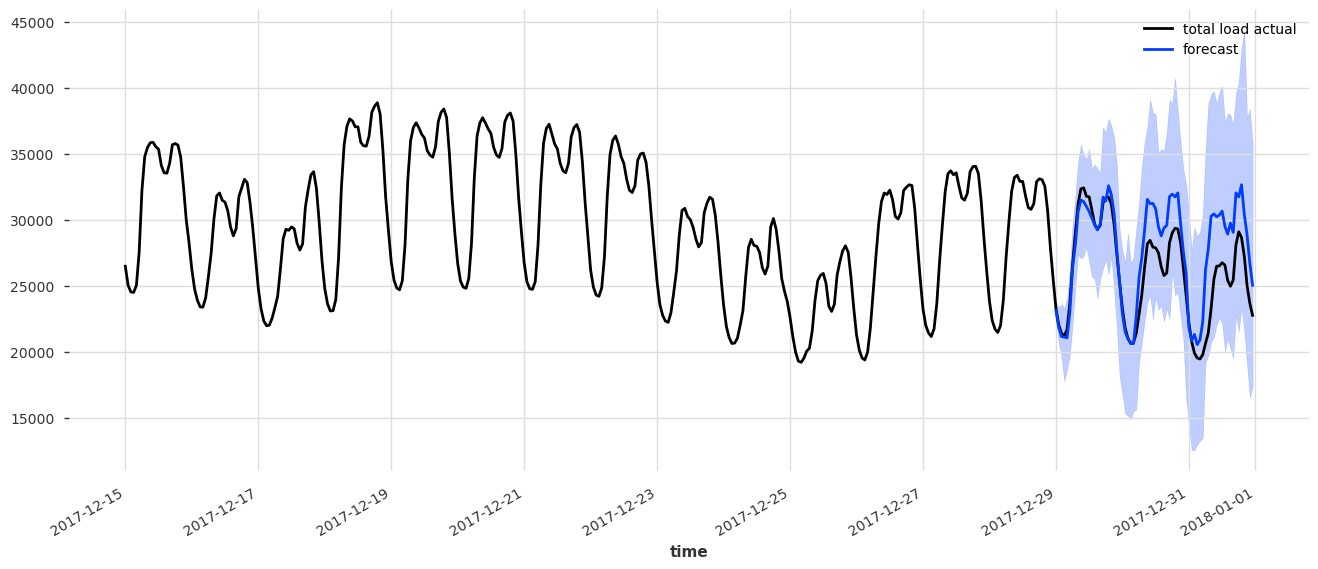

In [96]:
from darts.models.forecasting.sf_auto_arima import StatsForecastAutoARIMA
auto_arima = StatsForecastAutoARIMA()
auto_arima.fit(train_short, future_covariates=future_covariates)
train_and_val.plot()
auto_arima.predict(VAL_LEN, future_covariates=future_covariates, num_samples=100).plot(label="forecast")

# Back to Slides